# Final course project - Data Management Systems

In [1]:
# Loading important libraries
import re
import os
import glob
import pickle
from pymongo import MongoClient, UpdateOne
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import logging
from bson import ObjectId
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
# Function to convert large integers in the data
def convert_large_ints(data):
    if isinstance(data, dict):
        return {k: convert_large_ints(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_large_ints(v) for v in data]
    elif isinstance(data, int) and (data > 2*63 - 1 or data < -2*63):
        return str(data)
    else:
        return data

In [3]:
# Function to load data from a pickle file into a MongoDB collection
def load_pickle_to_mongo(file_path, collection):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        data = convert_large_ints(data)
        if isinstance(data, list):
            collection.insert_many(data)
        else:
            collection.insert_one(data)
    print(f"Loaded data from {file_path} into {collection.name}", flush=True)

In [4]:
# Function to load pickle files in batches
def load_files_in_batches(files, collection, batch_size=100):
    batch = []
    for file in files:
        with open(file, 'rb') as f:
            data = pickle.load(f)
            data = convert_large_ints(data)
            if isinstance(data, list):
                batch.extend(data)
            else:
                batch.append(data)
            if len(batch) >= batch_size:
                collection.insert_many(batch)
                batch.clear()
    if batch:
        collection.insert_many(batch)

# Connect to MongoDB

In [5]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['DMS_Project']  # Replace with your database name

In [6]:
# Configure logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Suppress debug logs for pymongo and matplotlib
logging.getLogger('pymongo').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [7]:
# Define paths to the folders containing the pickle files
data_paths = {
    'ether': '/Users/nick/Desktop/Course work/DMS Group coursework/dao-data-smm695/etherscan-data-collection/.data',
    'polygon': '/Users/nick/Desktop/Course work/DMS Group coursework/dao-data-smm695/polygonscan-data-collection/.data',
    'dao_info': '/Users/nick/Desktop/Course work/DMS Group coursework/dao-data-smm695/snap-data-collection/.data',
    'follows': '/Users/nick/Desktop/Course work/DMS Group coursework/dao-data-smm695/snap-data-collection/.data/follow',
    'votes': '/Users/nick/Desktop/Course work/DMS Group coursework/dao-data-smm695/snap-data-collection/.data/votes',
    'proposals': '/Users/nick/Desktop/Course work/DMS Group coursework/dao-data-smm695/snap-data-collection/.data/proposals'
}

# Collections
collections = {
    'polygon': db.polygon,
    'ether': db.ether,
    'dao_info': db.dao_info,
    'proposals': db.proposals,
    'votes': db.votes,
    'follows': db.follows
}

# Load data into MongoDB with multithreading
with ThreadPoolExecutor() as executor:
    futures = []
    for collection_name, path in data_paths.items():
        if collection_name == 'dao_info':
            dao_info_path = os.path.join(path, 'snap_dao_info.pickle')
            futures.append(executor.submit(load_pickle_to_mongo, dao_info_path, collections['dao_info']))
        else:
            files = glob.glob(os.path.join(path, '*.pickle'))
            futures.append(executor.submit(load_files_in_batches, files, collections[collection_name]))

    # Progress bar to monitor the tasks
    for future in tqdm(as_completed(futures), total=len(futures), desc="Loading data"):
        future.result()

print("Data loading complete.")

Loaded data from /Users/nick/Desktop/Course work/DMS Group coursework/dao-data-smm695/snap-data-collection/.data/snap_dao_info.pickle into dao_info


Loading data: 100%|██████████| 6/6 [02:16<00:00, 22.80s/it]

Data loading complete.


## Cleaning and preprocessing data

Step by Step

Step 1: Created new collection - Separates different components into respective collections, making the data easier to manage and query

Nested Structures:
-  Strategies: Contains details about different voting strategies.
- Treasuries: Contains treasury addresses.
- Validation: Contains validation rules and parameters.
- Admins: List of admin addresses.
- Members: List of member addresses.
- DAOs: Contains the main data structure with details about the DAO. Fields include id, name, rank, twitter, website, about, network, symbol, strategies, filters, plugins, treasuries, voting, validation, votesCount, activeProposals, proposalsCount, proposalsCount7d, and others.
- Spaces: Each DAO has multiple spaces.

Step 2: Cleaning each document and inserts its components into the respective collections.

a) Redundant Fields:
Removing fields that are consistently null or empty (e.g., email, github, website in some cases), fields with default values that don't vary much (e.g., blind, hideAbstain). Ensures that only valid and complete data are kept.

b) Normalization:
We did normalization to ensure data consistency, reduce errors, and simplify processing.
Like: Converts addresses to a consistent format (lowercase). Converts large numbers to strings if they exceed the maximum integer size. Ensures numeric fields are correctly formatted.

c) Type Inconsistencies:
We handled type inconsistencies to ensure uniform data formats, preventing errors in data processing and querying. This consistency improves accuracy and reliability in data analysis. 
For example: Fields like votesCount, activeProposals, proposalsCount, proposalsCount7d should be stored as integers instead of strings.

d) Remove Duplicates:
We removed duplicates to ensure data accuracy, reduce storage and processing costs, and maintain dataset integrity. 
Like here: Uses aggregation to group documents by unique combinations of address, blockNumber, and hash.
Deletes duplicate documents, keeping only one instance.

e) Unnecessary Nesting:
We nested data to simplify access to related hierarchical information, maintain data integrity, and enhance query performance by eliminating the need for joins. To ensures efficient retrieval of complete data structures and atomic updates, improving overall data management.
For example:  Nesting vote details within a document allows for easy retrieval of all votes associated with a specific proposal or voter. This is useful for querying all vote-related data in one go.

Step 3: Combined cleaning and restructuring process for each collection. 

### Dao Info

In [8]:

# Suppress debug logs for pymongo and matplotlib
logging.getLogger('pymongo').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['DMS_Project']

# Define the original cleaned_dao_info collection
cleaned_dao_info_collection = db['dao_info']

# Define the new collections
daos_collection = db['daos']
spaces_collection = db['spaces']
strategies_collection = db['strategies']
treasuries_collection = db['treasuries']
validation_collection = db['validation']
admins_collection = db['admins']
members_collection = db['members']

# Function to remove fields with null values 
# Cleaning the data to ensure only relevant information is kept, reducing redundancy and improving data quality.
def remove_null_fields(data):
    if isinstance(data, dict):
        return {k: remove_null_fields(v) for k, v in data.items() if v not in [None, "", []]}
    elif isinstance(data, list):
        return [remove_null_fields(v) for v in data if v not in [None, "", []]]
    else:
        return data

# Function to clean and restructure a single document
# Cleaning each document and inserts its components into the new collections.
def clean_and_restructure(doc):
    try:
        cleaned_doc = remove_null_fields(doc.get('data', {}))

        dao_id = daos_collection.insert_one({
            'data': cleaned_doc
        }).inserted_id
        logging.info(f"Inserted DAO with _id: {dao_id}")

        for space in cleaned_doc.get('spaces', []):
            space_id = ObjectId()
            space_data = {
                '_id': space_id,
                'dao_id': dao_id,
                'id': space.get('id', '').strip(),
                'name': space.get('name', '').strip(),
                'rank': int(space.get('rank', 0)),
                'twitter': space.get('twitter', '').strip(),
                'website': space.get('website', '').strip(),
                'about': space.get('about', '').strip(),
                'network': space.get('network', '').strip(),
                'symbol': space.get('symbol', '').strip(),
                'votesCount': int(space.get('votesCount', 0)),
                'activeProposals': int(space.get('activeProposals', 0)),
                'proposalsCount': int(space.get('proposalsCount', 0)),
                'proposalsCount7d': int(space.get('proposalsCount7d', 0)),
                'filters': space.get('filters', {}),
                'plugins': space.get('plugins', {}),
                'voting': space.get('voting', {})
            }
            spaces_collection.insert_one(space_data)
            logging.info(f"Inserted Space with _id: {space_id} for DAO with _id: {dao_id}")

            for strategy in space.get('strategies', []):
                strategy_id = strategies_collection.insert_one({
                    'space_id': space_id,
                    'name': strategy.get('name', '').strip(),
                    'params': strategy.get('params', {})
                }).inserted_id
                logging.info(f"Inserted Strategy with _id: {strategy_id} for Space with _id: {space_id}")

            for treasury in space.get('treasuries', []):
                treasury_id = treasuries_collection.insert_one({
                    'space_id': space_id,
                    'address': treasury.get('address', '').strip()
                }).inserted_id
                logging.info(f"Inserted Treasury with _id: {treasury_id} for Space with _id: {space_id}")

            validation = space.get('validation', {})
            validation_id = validation_collection.insert_one({
                'space_id': space_id,
                'name': validation.get('name', '').strip(),
                'params': validation.get('params', {})
            }).inserted_id
            logging.info(f"Inserted Validation with _id: {validation_id} for Space with _id: {space_id}")

            for admin in space.get('admins', []):
                admin_id = admins_collection.insert_one({
                    'space_id': space_id,
                    'address': admin
                }).inserted_id
                logging.info(f"Inserted Admin with _id: {admin_id} for Space with _id: {space_id}")

            for member in space.get('members', []):
                member_id = members_collection.insert_one({
                    'space_id': space_id,
                    'address': member
                }).inserted_id
                logging.info(f"Inserted Member with _id: {member_id} for Space with _id: {space_id}")

    except Exception as e:
        logging.error(f"Error cleaning and restructuring document: {e}")

# Combined cleaning and restructuring process for dao_info collection
def process_collection(collection):
    cursor = collection.find()
    for doc in cursor:
        clean_and_restructure(doc)

print("Processing cleaned_dao_info collection...")
process_collection(cleaned_dao_info_collection)
print("Data processing complete.")


Processing cleaned_dao_info collection...


2024-07-19 11:07:53,222 - INFO - Inserted DAO with _id: 669a3af952a48a16f7d73248
2024-07-19 11:07:53,275 - INFO - Inserted Space with _id: 669a3af952a48a16f7d73249 for DAO with _id: 669a3af952a48a16f7d73248
2024-07-19 11:07:53,299 - INFO - Inserted Strategy with _id: 669a3af952a48a16f7d7324a for Space with _id: 669a3af952a48a16f7d73249
2024-07-19 11:07:53,323 - INFO - Inserted Treasury with _id: 669a3af952a48a16f7d7324b for Space with _id: 669a3af952a48a16f7d73249
2024-07-19 11:07:53,352 - INFO - Inserted Validation with _id: 669a3af952a48a16f7d7324c for Space with _id: 669a3af952a48a16f7d73249
2024-07-19 11:07:53,352 - INFO - Inserted Space with _id: 669a3af952a48a16f7d7324d for DAO with _id: 669a3af952a48a16f7d73248
2024-07-19 11:07:53,353 - INFO - Inserted Strategy with _id: 669a3af952a48a16f7d7324e for Space with _id: 669a3af952a48a16f7d7324d
2024-07-19 11:07:53,354 - INFO - Inserted Validation with _id: 669a3af952a48a16f7d7324f for Space with _id: 669a3af952a48a16f7d7324d
2024-07-

Data processing complete.


### Proposals

In [9]:
# Define the original proposals collection
proposals_collection = db['proposals']
cleaned_proposals_collection = db['cleaned_proposals']

# Function to remove fields with null values
def remove_null_fields(data):
    if isinstance(data, dict):
        return {k: remove_null_fields(v) for k, v in data.items() if v not in [None, "", []]}
    elif isinstance(data, list):
        return [remove_null_fields(v) for v in data if v not in [None, "", []]]
    else:
        return data

# Function to clean a single proposal document
def clean_proposal(proposal):
    try:
        cleaned_proposal = remove_null_fields(proposal)
        return cleaned_proposal
    except Exception as e:
        logging.error(f"Error cleaning proposal {proposal['_id']}: {e}")
        return None

# Function to process the proposals collection
def process_proposals_collection(collection):
    cursor = collection.find()
    for proposal in cursor:
        cleaned_proposal = clean_proposal(proposal)
        if cleaned_proposal:
            cleaned_proposals_collection.replace_one({'_id': cleaned_proposal['_id']}, cleaned_proposal, upsert=True)

print("Processing proposals collection...")
process_proposals_collection(proposals_collection)
print("Data processing complete.")


Processing proposals collection...
Data processing complete.


### Follows

In [10]:
# Collection references
follows_collection = db['follows']
unnested_follows_collection = db['unnested_follows']

# Function to unnest follows data
def unnest_follows(document):
    unnested_documents = []
    for follow in document['data']['follows']:
        new_doc = {
            "original_id": document["_id"],  # Original document ID reference
            "follow_id": follow["id"],
            "ipfs": follow["ipfs"],
            "follower": follow["follower"],
            "space_id": follow["space"]["id"],
            "network": follow["network"],
            "created": follow["created"]
        }
        unnested_documents.append(new_doc)
    return unnested_documents

# Unnest and insert follows data
unnested_follows = []
for document in follows_collection.find():
    unnested_follows.extend(unnest_follows(document))
unnested_follows_collection.insert_many(unnested_follows)
print("Unnesting complete. Data stored in 'unnested_follows' collection.")

# Pipeline to identify duplicate entries
pipeline = [
    {
        "$group": {
            "_id": {
                "follow_id": "$follow_id",
                "space_id": "$space_id",
                "follower": "$follower"
            },
            "unique_ids": {"$addToSet": "$_id"},
            "count": {"$sum": 1}
        }
    },
    {"$match": {"count": {"$gt": 1}}},
    {"$project": {"unique_ids": {"$slice": ["$unique_ids", 1, {"$subtract": ["$count", 1]}]}}},
    {"$unwind": "$unique_ids"},
    {"$project": {"_id": "$unique_ids"}}
]

# Remove duplicates
duplicate_ids = [doc['_id'] for doc in unnested_follows_collection.aggregate(pipeline)]
unnested_follows_collection.delete_many({"_id": {"$in": duplicate_ids}})

# Remove entries with missing or null values in critical fields
unnested_follows_collection.delete_many({"$or": [
    {"follow_id": {"$exists": False, "$eq": None}},
    {"space_id": {"$exists": False, "$eq": None}},
    {"follower": {"$exists": False, "$eq": None}}
]})

# Normalize data: Convert space_id and follower to lowercase
unnested_follows_collection.update_many({}, [
    {"$set": {
        "space_id": {"$toLower": "$space_id"},
        "follower": {"$toLower": "$follower"}
    }}
])

# Remove invalid entries (e.g., space_id must end with .eth)
unnested_follows_collection.delete_many({"space_id": {"$not": {"$regex": "\\.eth$"}}})

print("Data cleaning complete.")

Unnesting complete. Data stored in 'unnested_follows' collection.
Data cleaning complete.


### Ether

In [11]:
# Collection reference
ether_collection = db['ether']

# Function to unnest transactions data
def unnest_transactions(document):
    unnested_documents = []
    for transaction in document['transactons']:
        new_doc = {
            "original_id": document["_id"],  # Store the original document ID for reference
            "address": document["address"],
            "current_balance": document["current_balance"],
            "blockNumber": transaction["blockNumber"],
            "timeStamp": transaction["timeStamp"],
            "hash": transaction["hash"],
            "nonce": transaction["nonce"],
            "blockHash": transaction["blockHash"],
            "transactionIndex": transaction["transactionIndex"],
            "from": transaction["from"],
            "to": transaction["to"],
            "value": transaction["value"],
            "gas": transaction["gas"],
            "gasPrice": transaction["gasPrice"],
            "isError": transaction["isError"],
            "txreceipt_status": transaction["txreceipt_status"],
            "input": transaction["input"],
            "contractAddress": transaction["contractAddress"],
            "cumulativeGasUsed": transaction["cumulativeGasUsed"],
            "gasUsed": transaction["gasUsed"],
            "confirmations": transaction["confirmations"],
            "methodId": transaction["methodId"],
            "functionName": transaction["functionName"]
        }
        unnested_documents.append(new_doc)
    return unnested_documents

# Process all documents in the ether collection
unnested_transactions = []
for document in ether_collection.find():
    unnested_transactions.extend(unnest_transactions(document))

# Insert the unnested data into a new collection
unnested_ether_collection = db['unnested_ether']
unnested_ether_collection.insert_many(unnested_transactions)

print("Unnesting complete. Data stored in 'unnested_ether' collection.")


Unnesting complete. Data stored in 'unnested_ether' collection.


In [12]:
# Collection reference
unnested_ether_collection = db['unnested_ether']

# Remove duplicates based on transaction hash and block number
pipeline = [
    {
        "$group": {
            "_id": {
                "hash": "$hash",
                "blockNumber": "$blockNumber"
            },
            "unique_ids": {"$addToSet": "$_id"},
            "count": {"$sum": 1}
        }
    },
    {
        "$match": {
            "count": {"$gt": 1}
        }
    },
    {
        "$project": {
            "unique_ids": {"$slice": ["$unique_ids", 1, {"$subtract": ["$count", 1]}]}
        }
    },
    {
        "$unwind": "$unique_ids"
    },
    {
        "$project": {
            "_id": "$unique_ids"
        }
    }
]

duplicate_ids_cursor = unnested_ether_collection.aggregate(pipeline)

batch_size = 1000
batch = []

for doc in duplicate_ids_cursor:
    batch.append(doc['_id'])
    if len(batch) == batch_size:
        unnested_ether_collection.delete_many({"_id": {"$in": batch}})
        batch = []

# Delete any remaining documents in the last batch
if batch:
    unnested_ether_collection.delete_many({"_id": {"$in": batch}})

# Remove entries with missing or null values in critical fields
unnested_ether_collection.delete_many({"$or": [
    {"hash": {"$exists": False}},
    {"hash": None},
    {"blockNumber": {"$exists": False}},
    {"blockNumber": None},
    {"from": {"$exists": False}},
    {"from": None},
    {"to": {"$exists": False}},
    {"to": None}
]})

# Normalize data: Convert addresses to lowercase
unnested_ether_collection.update_many({}, [
    {"$set": {
        "from": {"$toLower": "$from"},
        "to": {"$toLower": "$to"}
    }}
])

# Remove invalid entries (example: remove transactions to null address)
unnested_ether_collection.delete_many({"to": "0x0000000000000000000000000000000000000000"})

print("Data cleaning complete.")


Data cleaning complete.


### Polygon

In [13]:
# Collection reference
polygon_collection = db['polygon']

# Function to unnest transactions data
def unnest_transactions(document):
    unnested_documents = []
    for transaction in document['transactons']:
        new_doc = {
            "original_id": document["_id"],  # Store the original document ID for reference
            "address": document["address"],
            "current_balance": document["current_balance"],
            "blockNumber": transaction["blockNumber"],
            "timeStamp": transaction["timeStamp"],
            "hash": transaction["hash"],
            "nonce": transaction["nonce"],
            "blockHash": transaction["blockHash"],
            "transactionIndex": transaction["transactionIndex"],
            "from": transaction["from"],
            "to": transaction["to"],
            "value": transaction["value"],
            "gas": transaction["gas"],
            "gasPrice": transaction["gasPrice"],
            "isError": transaction["isError"],
            "txreceipt_status": transaction["txreceipt_status"],
            "input": transaction["input"],
            "contractAddress": transaction["contractAddress"],
            "cumulativeGasUsed": transaction["cumulativeGasUsed"],
            "gasUsed": transaction["gasUsed"],
            "confirmations": transaction["confirmations"],
            "methodId": transaction["methodId"],
            "functionName": transaction["functionName"]
        }
        unnested_documents.append(new_doc)
    return unnested_documents

# Process all documents in the polygonscan collection
unnested_transactions = []
for document in polygon_collection.find():
    unnested_transactions.extend(unnest_transactions(document))

# Insert the unnested data into a new collection
unnested_polygon_collection = db['unnested_polygon']
unnested_polygon_collection.insert_many(unnested_transactions)

print("Unnesting complete. Data stored in 'unnested_polygon' collection.")


Unnesting complete. Data stored in 'unnested_polygon' collection.


In [14]:
# Collection reference
unnested_polygon_collection = db['unnested_polygon']

# Function to clean data
def clean_data():
    bulk_updates = []
    max_int64 = 2**63 - 1

    for document in unnested_polygon_collection.find():
        update = {}

        # Ensure numeric fields are integers or strings if too large
        numeric_fields = ['blockNumber', 'timeStamp', 'nonce', 'transactionIndex', 'value', 'gas', 'gasPrice', 'cumulativeGasUsed', 'gasUsed', 'confirmations']
        for field in numeric_fields:
            if field in document and isinstance(document[field], str):
                try:
                    value = int(document[field])
                    if abs(value) > max_int64:
                        update[field] = str(value)
                    else:
                        update[field] = value
                except ValueError:
                    update[field] = None  # or some default value like 0

        # Ensure isError and txreceipt_status are integers or strings if too large
        if 'isError' in document:
            try:
                value = int(document['isError'])
                if abs(value) > max_int64:
                    update['isError'] = str(value)
                else:
                    update['isError'] = value
            except ValueError:
                update['isError'] = None
        if 'txreceipt_status' in document:
            try:
                value = int(document['txreceipt_status'])
                if abs(value) > max_int64:
                    update['txreceipt_status'] = str(value)
                else:
                    update['txreceipt_status'] = value
            except ValueError:
                update['txreceipt_status'] = None

        # Ensure current_balance is numeric or string if too large
        if 'current_balance' in document and isinstance(document['current_balance'], str):
            try:
                value = int(document['current_balance'])
                if abs(value) > max_int64:
                    update['current_balance'] = str(value)
                else:
                    update['current_balance'] = value
            except ValueError:
                update['current_balance'] = None  # or some default value like 0

        # Update if there are any changes
        if update:
            bulk_updates.append(UpdateOne({'_id': document['_id']}, {'$set': update}))

    # Execute bulk update
    if bulk_updates:
        result = unnested_polygon_collection.bulk_write(bulk_updates)
        print(f"Modified {result.modified_count} documents.")

# Function to remove duplicates
def remove_duplicates():
    pipeline = [
        {"$group": {
            "_id": {
                "address": "$address",
                "blockNumber": "$blockNumber",
                "hash": "$hash"
            },
            "uniqueIds": {"$addToSet": "$_id"},
            "count": {"$sum": 1}
        }},
        {"$match": {"count": {"$gt": 1}}}
    ]

    duplicate_records = list(unnested_polygon_collection.aggregate(pipeline))
    for record in duplicate_records:
        ids_to_keep = record['uniqueIds'][1:]
        unnested_polygon_collection.delete_many({"_id": {"$in": ids_to_keep}})

    print(f"Removed {len(duplicate_records)} duplicate records.")

# Function to check consistency of 'methodId' and 'functionName'
def check_consistency():
    count = unnested_polygon_collection.count_documents({"methodId": {"$exists": True, "$ne": ""}, "functionName": {"$exists": True, "$eq": ""}})
    print(f"Found {count} documents with 'methodId' but no 'functionName'.")

# Run the cleaning functions
clean_data()
remove_duplicates()
check_consistency()


Modified 1064437 documents.
Removed 0 duplicate records.
Found 149627 documents with 'methodId' but no 'functionName'.


### Votes

In [15]:
# Collection reference
votes_collection = db['votes']

# Function to unnest votes data
def unnest_votes(document):
    unnested_documents = []
    for vote in document['data']['votes']:
        new_doc = {
            "original_id": document["_id"],  # Store the original document ID for reference
            "vote_id": vote["id"],
            "voter": vote["voter"],
            "vp": vote["vp"],
            "vp_by_strategy": vote["vp_by_strategy"],
            "vp_state": vote["vp_state"],
            "created": vote["created"],
            "proposal_choice": vote["proposal"].get("choice", None),  # Use .get() to handle missing 'choice'
            "space_id": vote["space"]["id"]
        }
        unnested_documents.append(new_doc)
    return unnested_documents

# Process all documents in the votes collection
unnested_votes = []
for document in votes_collection.find():
    unnested_votes.extend(unnest_votes(document))

# Insert the unnested data into a new collection
unnested_votes_collection = db['unnested_votes']
if unnested_votes:  # Check if there is any data to insert
    unnested_votes_collection.insert_many(unnested_votes)

print("Unnesting complete. Data stored in 'unnested_votes' collection.")


Unnesting complete. Data stored in 'unnested_votes' collection.


## Analysis and Insights

## 1. DAO Popularity and Engagement Analysis

In [16]:
# Collection reference
unnested_follows_collection = db['unnested_follows']

# Aggregation pipeline to find the top 10 space IDs based on number of follows
pipeline = [
    {
        "$group": {
            "_id": "$space_id",
            "count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "count": -1 }
    },
    {
        "$limit": 10
    }
]

# Execute the aggregation pipeline
top_spaces = unnested_follows_collection.aggregate(pipeline)

# Print the top 10 space IDs based on number of follows
print("Top 10 space IDs based on number of follows:")
for space in top_spaces:
    print(f"Space ID: {space['_id']}, Number of Follows: {space['count']}")


Top 10 space IDs based on number of follows:
Space ID: stgdao.eth, Number of Follows: 40979
Space ID: arbitrumfoundation.eth, Number of Follows: 37723
Space ID: opcollective.eth, Number of Follows: 25720
Space ID: aave.eth, Number of Follows: 17785
Space ID: uniswapgovernance.eth, Number of Follows: 15037
Space ID: gitcoindao.eth, Number of Follows: 14385
Space ID: cakevote.eth, Number of Follows: 13480
Space ID: gmx.eth, Number of Follows: 13294
Space ID: ens.eth, Number of Follows: 12066
Space ID: bitdao.eth, Number of Follows: 9744


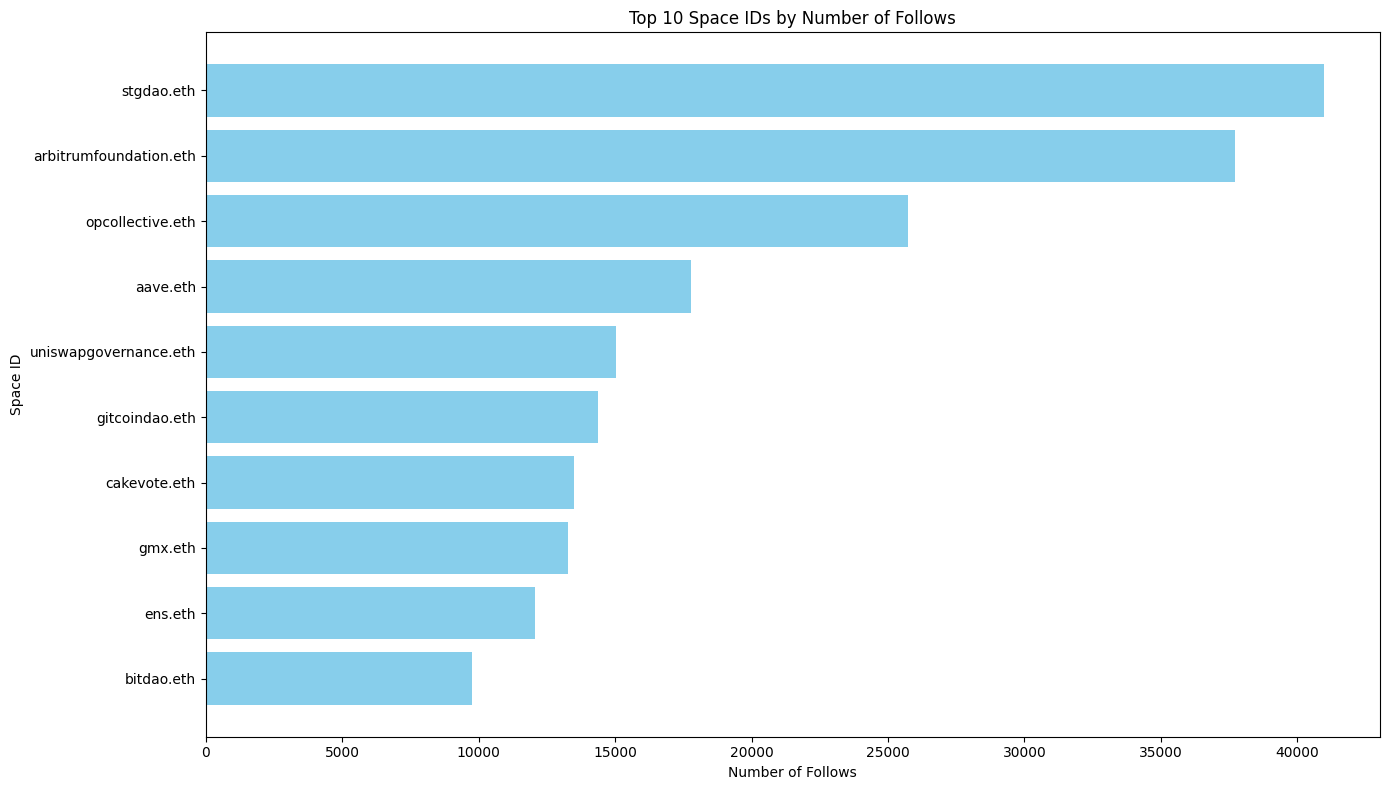

In [17]:
# Data for the plot
space_ids = [
    "stgdao.eth",
    "arbitrumfoundation.eth",
    "opcollective.eth",
    "aave.eth",
    "uniswapgovernance.eth",
    "gitcoindao.eth",
    "cakevote.eth",
    "gmx.eth",
    "ens.eth",
    "bitdao.eth"
]

follow_counts = [
    40979,
    37723,
    25720,
    17785,
    15037,
    14385,
    13480,
    13294,
    12066,
    9744
]

# Plotting
plt.figure(figsize=(14, 8))
plt.barh(space_ids, follow_counts, color='skyblue')
plt.xlabel('Number of Follows')
plt.ylabel('Space ID')
plt.title('Top 10 Space IDs by Number of Follows')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.tight_layout()

# Show the plot
plt.show()


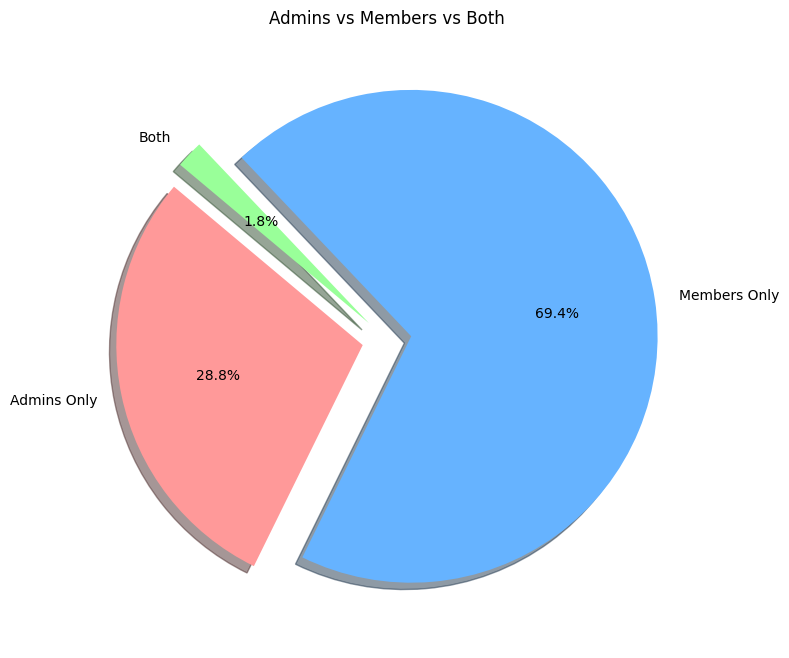

In [18]:
# Collection reference
admins_collection = db['admins']
members_collection = db['members']

# Get all admin addresses
admin_addresses = set(admins_collection.distinct('address'))

# Get all member addresses
member_addresses = set(members_collection.distinct('address'))

# Find common addresses
common_addresses = admin_addresses.intersection(member_addresses)

# Plotting
labels = ['Admins Only', 'Members Only', 'Both']
sizes = [len(admin_addresses - common_addresses), len(member_addresses - common_addresses), len(common_addresses)]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0.1, 0.1)  # explode all slices

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Admins vs Members vs Both')
plt.show()


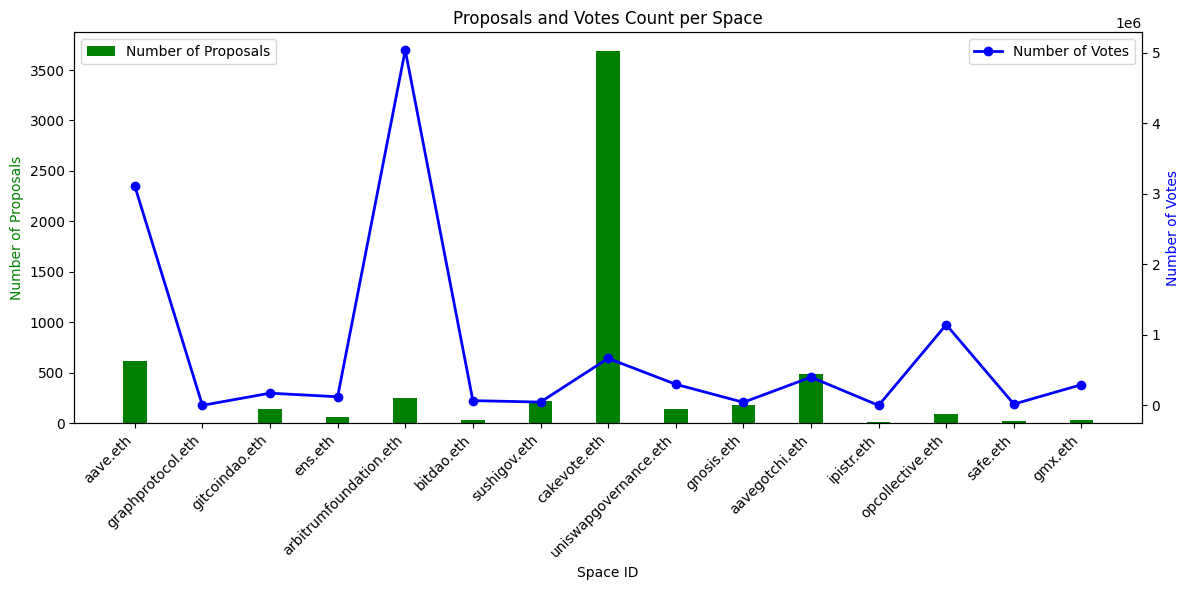

In [19]:
# Collection reference
spaces_collection = db['spaces']
proposals_collection = db['cleaned_proposals']

# Fetch proposal counts per space
proposal_counts = proposals_collection.aggregate([
    {"$unwind": "$data.proposals"},
    {"$group": {"_id": "$data.proposals.space.id", "proposal_count": {"$sum": 1}}}
])

# Fetch vote counts per space
vote_counts = spaces_collection.find({}, {"_id": 0, "id": 1, "votesCount": 1})

# Create dictionaries for easy lookup
proposal_count_dict = {item['_id']: item['proposal_count'] for item in proposal_counts}
vote_count_dict = {item['id']: item['votesCount'] for item in vote_counts}

# Create lists for plotting
space_ids = list(set(proposal_count_dict.keys()).intersection(set(vote_count_dict.keys())))
proposals = [proposal_count_dict[space] for space in space_ids]
votes = [vote_count_dict[space] for space in space_ids]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Adjusting bar width and position
bar_width = 0.35
bar_positions = range(len(space_ids))

ax1.bar(bar_positions, proposals, bar_width, color='g', label='Number of Proposals')
ax2 = ax1.twinx()
ax2.plot(bar_positions, votes, color='b', marker='o', linestyle='-', linewidth=2, label='Number of Votes')

ax1.set_xlabel('Space ID')
ax1.set_ylabel('Number of Proposals', color='g')
ax2.set_ylabel('Number of Votes', color='b')

ax1.set_xticks(bar_positions)
ax1.set_xticklabels(space_ids, rotation=45, ha='right')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Proposals and Votes Count per Space')
plt.tight_layout()
plt.show()


## 2) DAO Governance Processes:

### Common Voting Strategies

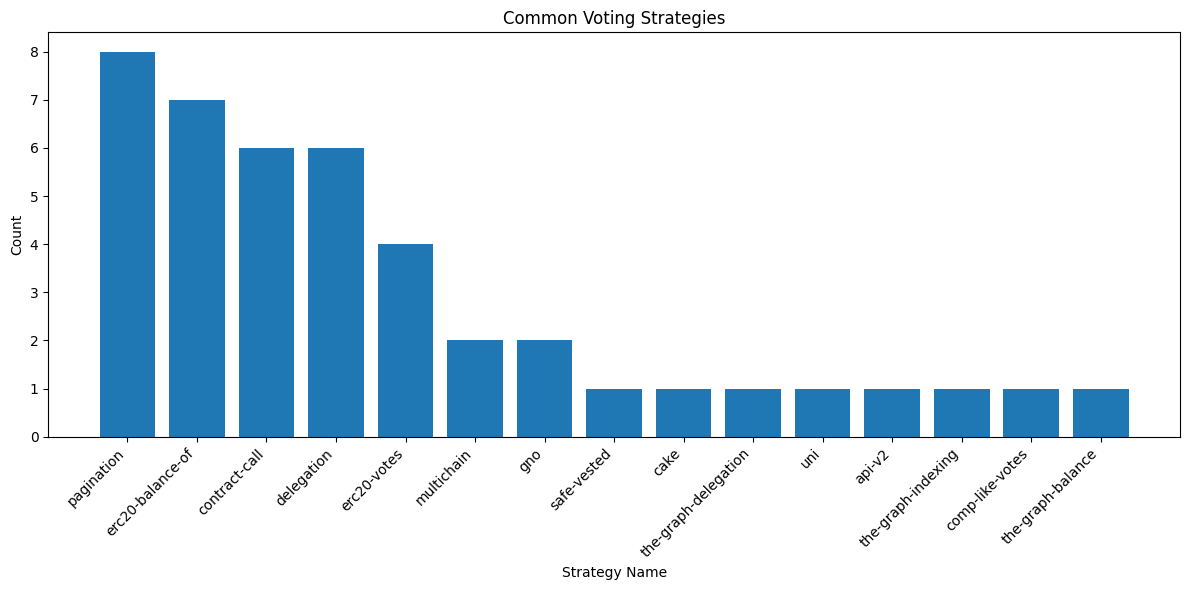

In [20]:
# Collection reference
strategies_collection = db['strategies']

# Group by strategy name and count occurrences
pipeline = [
    {"$group": {"_id": "$name", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]
results = list(strategies_collection.aggregate(pipeline))

# Extract data for plotting
strategy_names = [result['_id'] for result in results]
strategy_counts = [result['count'] for result in results]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(strategy_names, strategy_counts)
plt.xlabel('Strategy Name')
plt.ylabel('Count')
plt.title('Common Voting Strategies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Voting Power Distribution

[{'_id': '0x0eB5B03c0303f2F47cD81d7BE4275AF8Ed347576', 'total_vp': 4675071981.109306}, {'_id': '0x1B686eE8E31c5959D9F5BBd8122a58682788eeaD', 'total_vp': 4248507165.8472137}, {'_id': '0x3e8734Ec146C981E3eD1f6b582D447DDE701d90c', 'total_vp': 3382258644.5445423}, {'_id': '0x4a9ECB3D1aFe6177936EE996F5F84DEab73d9e07', 'total_vp': 3220349599.1196394}, {'_id': '0xF4B0556B9B6F53E00A1FDD2b0478Ce841991D8fA', 'total_vp': 3193555395.211197}, {'_id': '0x72aC0daC4784d1B0F6F15cEB4eE918c40AAda55b', 'total_vp': 3156716639.693515}, {'_id': '0x839395e20bbB182fa440d08F850E6c7A8f6F0780', 'total_vp': 1882778400.2516246}, {'_id': '0x11cd09a0c5B1dc674615783b0772a9bFD53e3A8F', 'total_vp': 1316807921.798708}, {'_id': '0x09da12f0977eD3534124a4f593D9C1a243beA598', 'total_vp': 1144730718.9439578}, {'_id': '0xF92F185AbD9E00F56cb11B0b709029633d1E37B4', 'total_vp': 1051238939.6237552}]


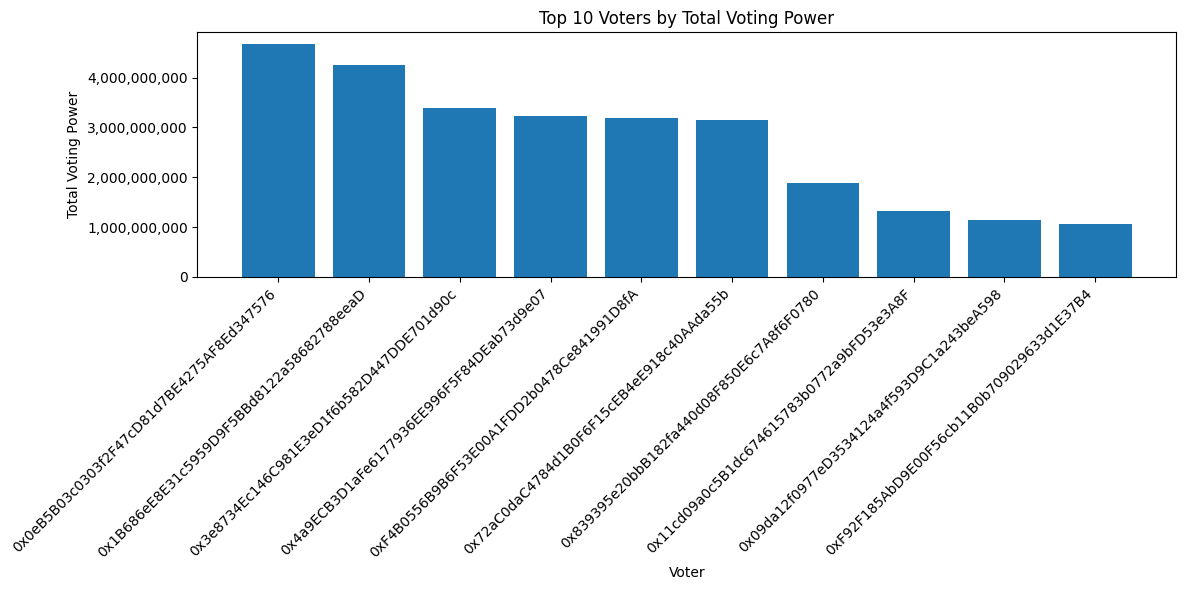

In [21]:
# Collection reference
unnested_votes_collection = db['unnested_votes']

# Analyze the distribution of voting power among different voters
voter_influence = list(unnested_votes_collection.aggregate([
    {"$group": {"_id": "$voter", "total_vp": {"$sum": "$vp"}}},
    {"$sort": {"total_vp": -1}},
    {"$limit": 10}
]))

# Debug: print the results
print(voter_influence)

# Create lists for plotting
voters = [item['_id'] for item in voter_influence]
voting_power = [item['total_vp'] for item in voter_influence]

# Function to format y-axis values
def thousands_formatter(x, pos):
    return '{:,.0f}'.format(x)

# Check if we have data to plot
if voters and voting_power:
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(voters, voting_power)
    plt.xlabel('Voter')
    plt.ylabel('Total Voting Power')
    plt.title('Top 10 Voters by Total Voting Power')
    plt.xticks(rotation=45, ha='right')
    
    # Apply the custom formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot.")

## 3) Blockchain Transaction Analysis

### Transaction Volume Over Time

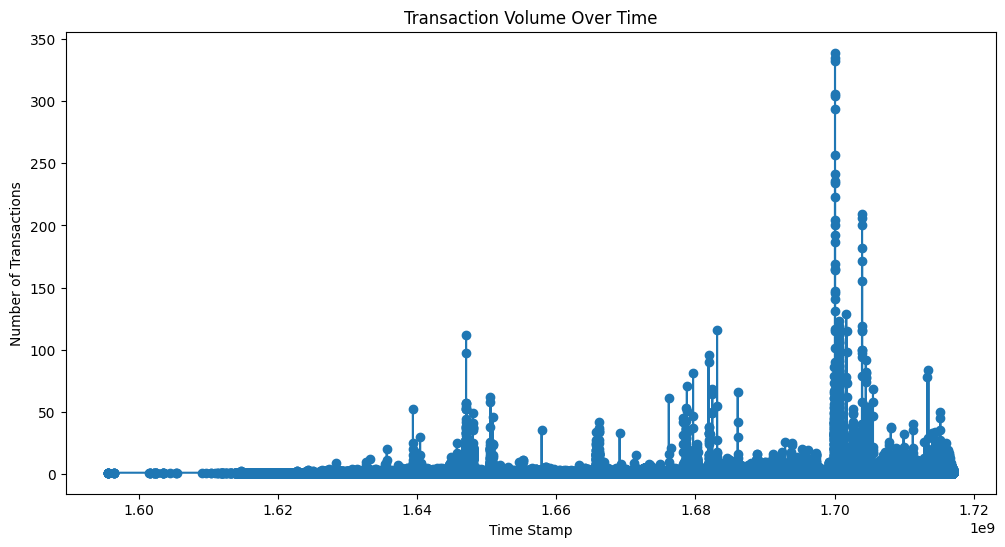

In [22]:
# Collection reference
unnested_polygon_collection = db['unnested_polygon']

# Transaction Volume Over Time
def transaction_volume_over_time():
    pipeline = [
        {"$group": {"_id": "$timeStamp", "count": {"$sum": 1}}},
        {"$sort": {"_id": 1}}
    ]
    results = list(unnested_polygon_collection.aggregate(pipeline))
    time_stamps = [int(result['_id']) for result in results]
    counts = [result['count'] for result in results]

    plt.figure(figsize=(12, 6))
    plt.plot(time_stamps, counts, marker='o')
    plt.xlabel('Time Stamp')
    plt.ylabel('Number of Transactions')
    plt.title('Transaction Volume Over Time')
    plt.show()

# Call the function to generate the plot
transaction_volume_over_time()


### Total Value Transferred Over Time

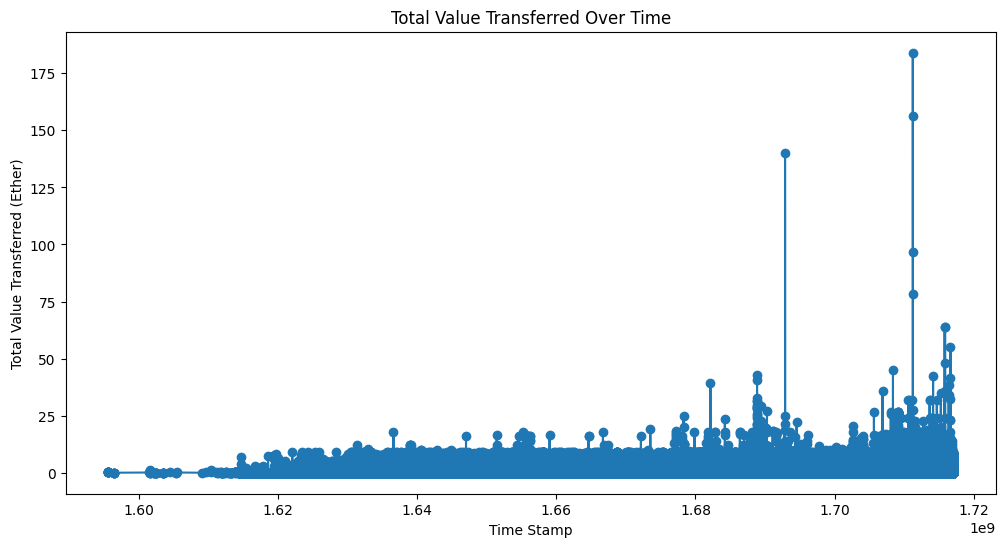

In [23]:
# Value Transfer Analysis
def value_transfer_analysis():
    pipeline = [
        {"$group": {"_id": "$timeStamp", "totalValue": {"$sum": "$value"}}},
        {"$sort": {"_id": 1}}
    ]
    results = list(unnested_polygon_collection.aggregate(pipeline))
    time_stamps = [int(result['_id']) for result in results]
    total_values = [int(result['totalValue']) / 10**18 for result in results]  # Convert Wei to Ether

    plt.figure(figsize=(12, 6))
    plt.plot(time_stamps, total_values, marker='o')
    plt.xlabel('Time Stamp')
    plt.ylabel('Total Value Transferred (Ether)')
    plt.title('Total Value Transferred Over Time')
    plt.show()

# Call the function to generate the plot
value_transfer_analysis()

### Top Participants in Transactions

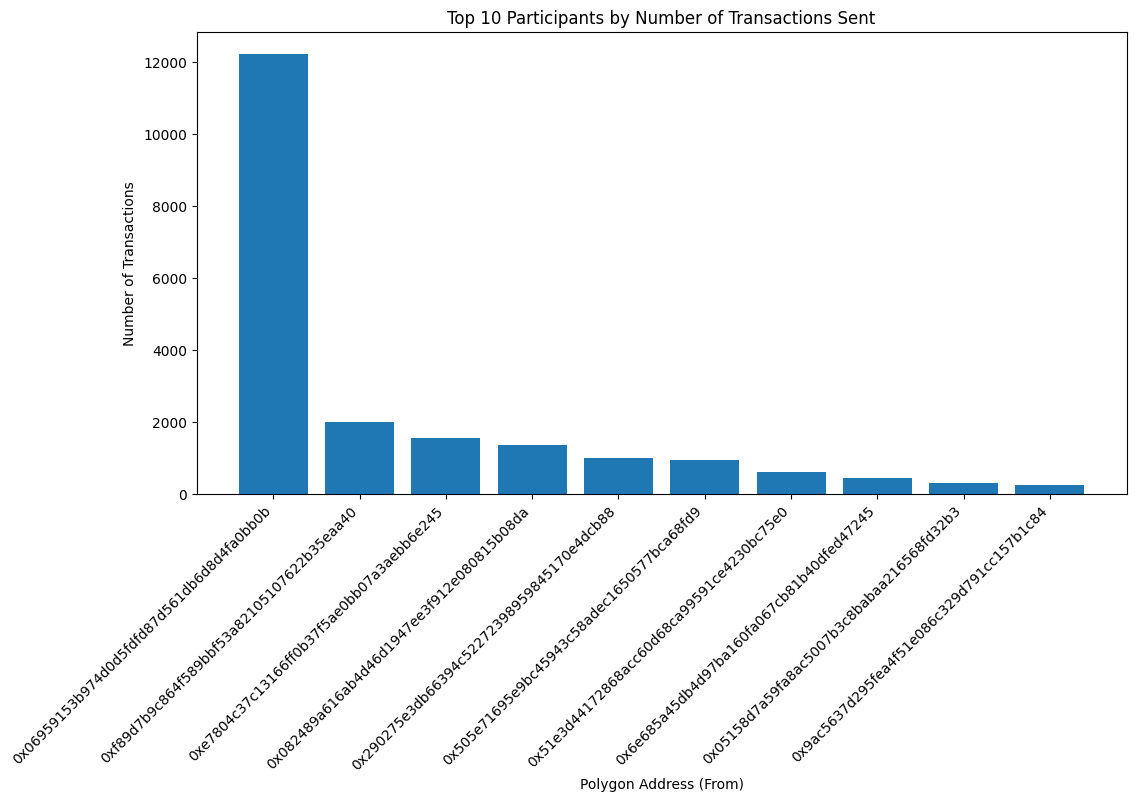

In [24]:
# Top Participants
def top_participants():
    pipeline = [
        {"$group": {"_id": "$from", "count": {"$sum": 1}}},
        {"$sort": {"count": -1}},
        {"$limit": 10}
    ]
    results = list(unnested_polygon_collection.aggregate(pipeline))
    addresses = [result['_id'] for result in results]
    counts = [result['count'] for result in results]

    plt.figure(figsize=(12, 6))
    plt.bar(addresses, counts)
    plt.xlabel('Polygon Address (From)')
    plt.ylabel('Number of Transactions')
    plt.title('Top 10 Participants by Number of Transactions Sent')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Call the function to generate the plot
top_participants()


## 4) Operational Efficiency:

### Ether Gas Fee Analysis

In [25]:
# Collection reference
unnested_ether_collection = db['unnested_ether']

# Function to calculate total gas fees
def calculate_total_gas_fees(document):
    gas_used = int(document['gasUsed'])
    gas_price = int(document['gasPrice'])
    gas_fee = gas_used * gas_price
    return gas_fee

# Process all documents in the unnested_ether collection
total_gas_fees = 0
for document in unnested_ether_collection.find():
    total_gas_fees += calculate_total_gas_fees(document)

# Convert the total gas fees from Wei to Ether (1 Ether = 10^18 Wei)
total_gas_fees_ether = total_gas_fees / 10**18

print(f"Total gas fees for Ether: {total_gas_fees} Wei ({total_gas_fees_ether} Ether)")


Total gas fees for Ether: 873458230403084421096 Wei (873.4582304030844 Ether)


### Polygon Gas Fee Analysis

In [26]:
# Collection reference
unnested_polygon_collection = db['unnested_polygon']

# Function to calculate total gas fees
def calculate_total_gas_fees(document):
    gas_used = int(document['gasUsed'])
    gas_price = int(document['gasPrice'])
    gas_fee = gas_used * gas_price
    return gas_fee

# Process all documents in the unnested_polygon collection
total_gas_fees = 0
for document in unnested_polygon_collection.find():
    total_gas_fees += calculate_total_gas_fees(document)

# Convert the total gas fees from Wei to Ether (1 Ether = 10^18 Wei)
total_gas_fees_ether = total_gas_fees / 10**18

print(f"Total gas fees for Polygon: {total_gas_fees} Wei ({total_gas_fees_ether} Ether)")


Total gas fees for Polygon: 17815747514356339002419 Wei (17815.74751435634 Ether)


### Average Gas Fee Per Transaction for Ether and Polygon

In [27]:
# Collection references
unnested_ether_collection = db['unnested_ether']
unnested_polygon_collection = db['unnested_polygon']

# Function to calculate total gas fees and count transactions
def calculate_total_gas_fees_and_count(transactions):
    total_gas_fees = 0
    count = 0
    for tx in transactions:
        gas_used = int(tx['gasUsed'])
        gas_price = int(tx['gasPrice'])
        gas_fee = gas_used * gas_price
        total_gas_fees += gas_fee
        count += 1
    return total_gas_fees, count

# Calculate for Unnested Ether
total_gas_fees_ether = 0
total_transactions_ether = 0
for document in unnested_ether_collection.find():
    transactions = [document]  # Each document represents a single transaction
    gas_fees, count = calculate_total_gas_fees_and_count(transactions)
    total_gas_fees_ether += gas_fees
    total_transactions_ether += count

average_gas_fee_ether = total_gas_fees_ether / total_transactions_ether if total_transactions_ether > 0 else 0

# Calculate for Unnested Polygon
total_gas_fees_polygon = 0
total_transactions_polygon = 0
for document in unnested_polygon_collection.find():
    transactions = [document]  # Each document represents a single transaction
    gas_fees, count = calculate_total_gas_fees_and_count(transactions)
    total_gas_fees_polygon += gas_fees
    total_transactions_polygon += count

average_gas_fee_polygon = total_gas_fees_polygon / total_transactions_polygon if total_transactions_polygon > 0 else 0

# Convert to Ether
average_gas_fee_ether_ether = average_gas_fee_ether / 10**18
average_gas_fee_polygon_ether = average_gas_fee_polygon / 10**18

print(f"Total transactions for Unnested Ether: {total_transactions_ether}")
print(f"Total transactions for Unnested Polygon: {total_transactions_polygon}")
print(f"Average gas fee per transaction for Unnested Ether: {average_gas_fee_ether} Wei ({average_gas_fee_ether_ether} Ether)")
print(f"Average gas fee per transaction for Unnested Polygon: {average_gas_fee_polygon} Wei ({average_gas_fee_polygon_ether} Ether)")


Total transactions for Unnested Ether: 586170
Total transactions for Unnested Polygon: 1064437
Average gas fee per transaction for Unnested Ether: 1490110770600823.0 Wei (0.001490110770600823 Ether)
Average gas fee per transaction for Unnested Polygon: 1.6737249376295956e+16 Wei (0.016737249376295955 Ether)


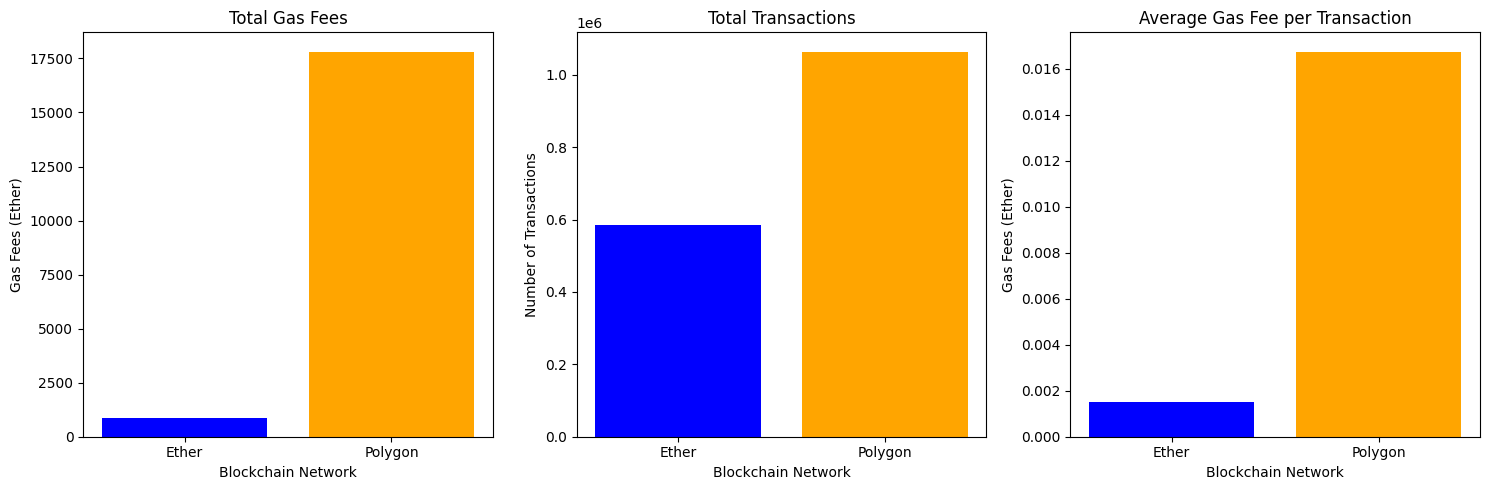

In [28]:
# Data for plotting
networks = ['Ether', 'Polygon']
total_gas_fees_ether = [873.458, 17815.748]  # Rounded for better readability
total_transactions = [586170, 1064437]
average_gas_fee_ether = [0.00149, 0.01674]  # Rounded for better readability

# Plotting Total Gas Fees
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(networks, total_gas_fees_ether, color=['blue', 'orange'])
plt.title('Total Gas Fees')
plt.ylabel('Gas Fees (Ether)')
plt.xlabel('Blockchain Network')

# Plotting Total Transactions
plt.subplot(1, 3, 2)
plt.bar(networks, total_transactions, color=['blue', 'orange'])
plt.title('Total Transactions')
plt.ylabel('Number of Transactions')
plt.xlabel('Blockchain Network')

# Plotting Average Gas Fee per Transaction
plt.subplot(1, 3, 3)
plt.bar(networks, average_gas_fee_ether, color=['blue', 'orange'])
plt.title('Average Gas Fee per Transaction')
plt.ylabel('Gas Fees (Ether)')
plt.xlabel('Blockchain Network')

plt.tight_layout()
plt.show()


## Appendix

### Data Review

In [29]:
# Collection reference
spaces_collection = db['spaces']

# Calculate total proposals
total_proposals = spaces_collection.aggregate([
    {"$group": {"_id": None, "totalProposals": {"$sum": "$proposalsCount"}}}
])

for result in total_proposals:
    print(f"Total Proposals: {result['totalProposals']}")

Total Proposals: 6014


In [30]:
# Collection reference
treasuries_collection = db['treasuries']

# Total treasury count and addresses
total_treasuries = treasuries_collection.count_documents({})
print(f"Total Treasuries: {total_treasuries}")

# Treasury details
treasury_details = treasuries_collection.find({}, {"_id": 0, "space_id": 1, "address": 1})
for treasury in treasury_details:
    print(treasury)

Total Treasuries: 8
{'space_id': ObjectId('669a3af952a48a16f7d73249'), 'address': '0x544cBe6698E2e3b676C76097305bBa588dEfB13A'}
{'space_id': ObjectId('669a3af952a48a16f7d7327f'), 'address': '0x78605Df79524164911C144801f41e9811B7DB73D'}
{'space_id': ObjectId('669a3af952a48a16f7d7329c'), 'address': '0xe94b5eec1fa96ceecbd33ef5baa8d00e4493f4f3'}
{'space_id': ObjectId('669a3af952a48a16f7d732a4'), 'address': '0x57a8865cfB1eCEf7253c27da6B4BC3dAEE5Be518'}
{'space_id': ObjectId('669a3af952a48a16f7d732a4'), 'address': '0xde21F729137C5Af1b01d73aF1dC21eFfa2B8a0d6'}
{'space_id': ObjectId('669a3af952a48a16f7d732df'), 'address': '0xb208f8BB431f580CC4b216826AFfB128cd1431aB'}
{'space_id': ObjectId('669a3af952a48a16f7d732df'), 'address': '0x27DF5C6dcd360f372e23d5e63645eC0072D0C098'}
{'space_id': ObjectId('669a3af952a48a16f7d732df'), 'address': '0xFFE6280ae4E864D9aF836B562359FD828EcE8020'}


Total Number of Treasuries:
The total number of treasuries across all DAOs is 8, indicating that only a subset of the DAOs have established treasuries. This could reflect on the financial organization and resource allocation within these DAOs.

Treasury Details:
The details of each treasury, including the space_id and address, provide specific information on which DAOs have treasuries and their corresponding blockchain addresses.

In [31]:
# Calculate total votes
total_votes = votes_collection.count_documents({})

# Calculate total proposals
total_proposals = proposals_collection.count_documents({})

# Calculate average votes per proposal
if total_proposals > 0:
    average_votes_per_proposal = total_votes / total_proposals
    print(f"Average Votes per Proposal: {average_votes_per_proposal}")
else:
    print("No proposals found.")

Average Votes per Proposal: 513.3888888888889


Average Votes per Proposal:
The result (Average Votes per Proposal: 513.3888888888889) indicates that, on average, each proposal receives approximately 513 votes. This metric provides an understanding of the level of engagement and participation in the governance process across the DAOs.

In [32]:
# Collection reference
spaces_collection = db['spaces']

# Retrieve the list of space IDs
space_ids = spaces_collection.distinct('id')

print("List of Space IDs list of 15 Decentralized Autonomous Organizations (DAOs):")
for space_id in space_ids:
    print(space_id)

List of Space IDs list of 15 Decentralized Autonomous Organizations (DAOs):
aave.eth
aavegotchi.eth
arbitrumfoundation.eth
bitdao.eth
cakevote.eth
ens.eth
gitcoindao.eth
gmx.eth
gnosis.eth
graphprotocol.eth
ipistr.eth
opcollective.eth
safe.eth
sushigov.eth
uniswapgovernance.eth


In [33]:
# Collection reference
unnested_follows_collection = db['unnested_follows']

# Aggregation pipeline to calculate the total number of follows
pipeline = [
    {"$group": {"_id": None, "totalFollows": {"$sum": 1}}}  # Group by None and sum follows
]

# Execute the aggregation pipeline
total_follows = list(unnested_follows_collection.aggregate(pipeline))

# Print the total number of follows
if total_follows:
    total_follows_count = total_follows[0]['totalFollows']
    print(f"Total number of follows: {total_follows_count}")
else:
    print("No follows found in the collection.")

Total number of follows: 434295


Total Number of Follows:
The total number of follows across all DAOs in the dataset is 434,295. This metric indicates the level of interest and engagement from users within these communities.

#### Vote count for each DAOs space ids

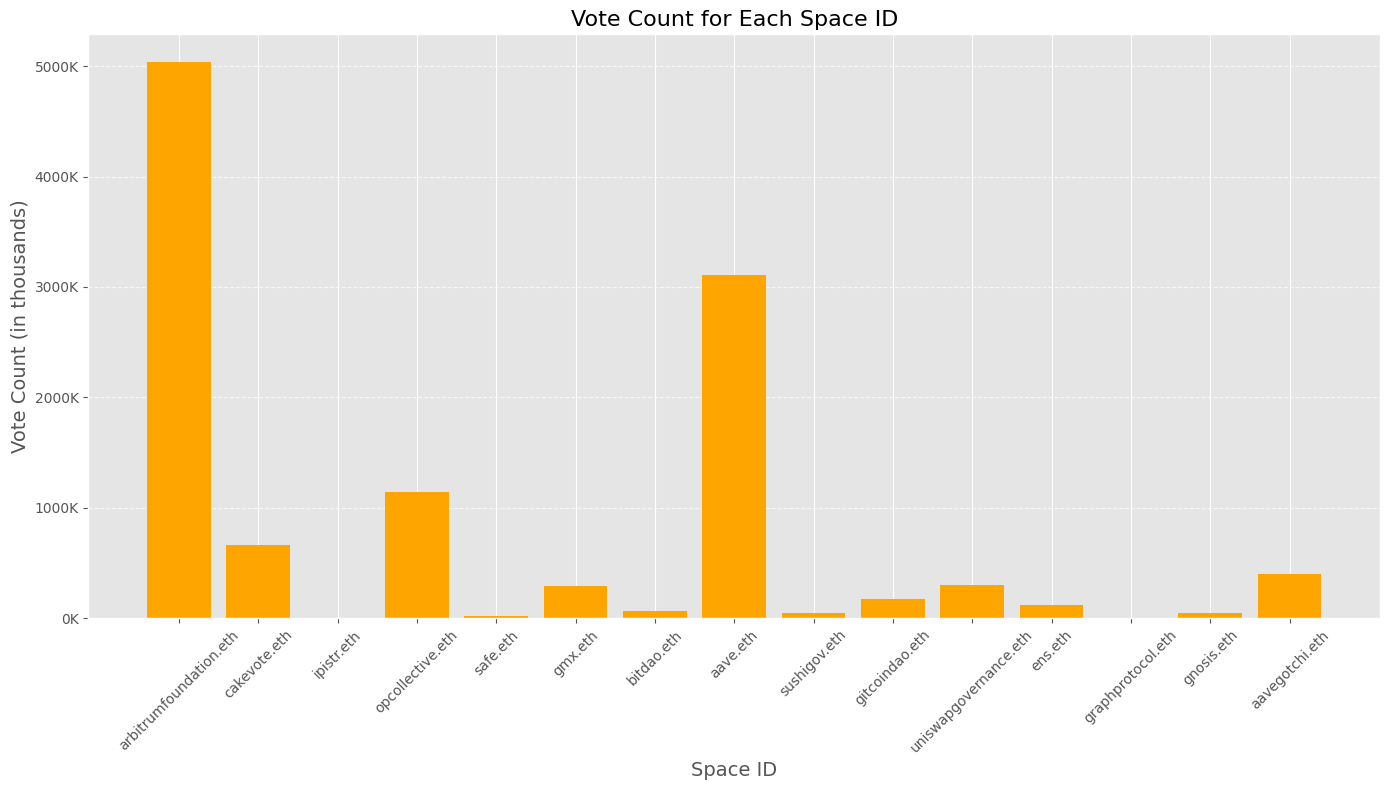

In [34]:
# Collection reference
spaces_collection = db['spaces']

# Retrieve space IDs and their vote counts
spaces = spaces_collection.find({}, {"id": 1, "votesCount": 1})

# Prepare data for plotting
space_ids = []
vote_counts = []

for space in spaces:
    space_ids.append(space['id'])
    vote_counts.append(space.get('votesCount', 0))

# Function to format y-axis labels in thousands
def thousands(x, pos):
    return '%1.0fK' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Plotting the results
plt.style.use('ggplot')
plt.figure(figsize=(14, 8))
plt.bar(space_ids, vote_counts, color='orange')
plt.xlabel('Space ID', fontsize=14)
plt.ylabel('Vote Count (in thousands)', fontsize=14)
plt.title('Vote Count for Each Space ID', fontsize=16)
plt.xticks(rotation=45, ha='center')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


# Display the plot
plt.show()

The bar chart visualizes the vote counts for each space ID, providing insights into the level of participation in governance activities across different DAOs. Here is an analysis based on the chart and the vote counts:

1) Top DAOs by Vote Count:

arbitrumfoundation.eth has the highest vote count, exceeding 500,000 votes. This indicates extremely high engagement and participation in governance decisions within this DAO.
aave.eth also shows a substantial number of votes, indicating strong participation with over 200,000 votes.

2) Moderately Active DAOs:

DAOs like opcollective.eth, cakevote.eth, and aavegotchi.eth exhibit moderate vote counts, reflecting decent levels of community engagement and participation.

3) Less Active DAOs:

DAOs such as gmx.eth, bitdao.eth, gitcoindao.eth, uniswapgovernance.eth, and ens.eth have relatively lower vote counts, suggesting either a smaller community or less engagement in governance activities.

Significance
1) Engagement in Governance: High vote counts are indicative of active community involvement in governance decisions. DAOs with higher vote counts likely have robust processes for proposal submission and voting, fostering a democratic and participatory environment.
2) Community Size and Activity: The vote counts can serve as a proxy for the size and activity level of the community within each DAO. Higher vote counts often correlate with larger and more active communities.
3) Comparative Analysis: Comparing the vote counts across different DAOs can help identify which DAOs are more successful in engaging their members in governance activities.

### Admins Collection: Number of administrators per space

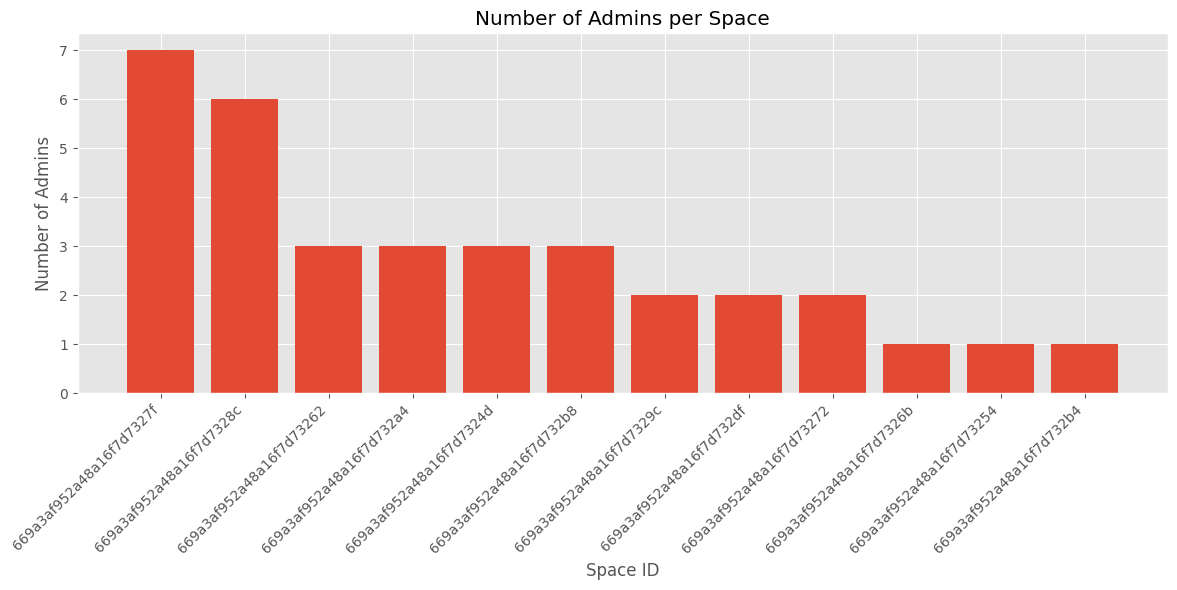

In [35]:
# Collection reference
admins_collection = db['admins']

# Group by space_id and count the number of admins
pipeline = [
    {"$group": {"_id": "$space_id", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]
results = list(admins_collection.aggregate(pipeline))

# Extract data for plotting
space_ids = [str(result['_id']) for result in results]  # Convert ObjectId to string
admin_counts = [result['count'] for result in results]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(space_ids, admin_counts)
plt.xlabel('Space ID')
plt.ylabel('Number of Admins')
plt.title('Number of Admins per Space')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The bar chart visualizes the number of admins per space for each DAO, providing insights into the administrative structure of the DAOs. Here is an analysis based on the chart and the number of admins:

1) Spaces with High Number of Admins:
The space ID 6699aa29ee01d3bd9737b77c has the highest number of admins, with 7 admins.
The space ID 6699aa29ee01d3bd9737b789 follows with 6 admins.

2) Moderately Administered Spaces:
Several space IDs, including 6699aa29ee01d3bd9737b7b5, 6699aa28ee01d3bd9737b74a, 6699aa2aee01d3bd9737b75f, 6699aa29ee01d3bd9737b7f5, and 6699aa2aee01d3bd9737b7dc, have 3 to 4 admins.

3) Spaces with Few Admins:
Space IDs such as 6699aa29ee01d3bd9737b751, 6699aa2aee01d3bd9737b799, and 6699aa29ee01d3bd9737b768 have fewer admins, typically around 1 to 2.

Significance
- Administrative Structure: More admins suggest a distributed model, enhancing transparency and decision-making.
- Governance: Higher number of admins may indicate collaborative governance, while fewer suggest centralized control.
- Resource Allocation: More admins can better manage governance aspects, like proposal evaluation and community engagement.


### Spaces with the highest rank or votes count

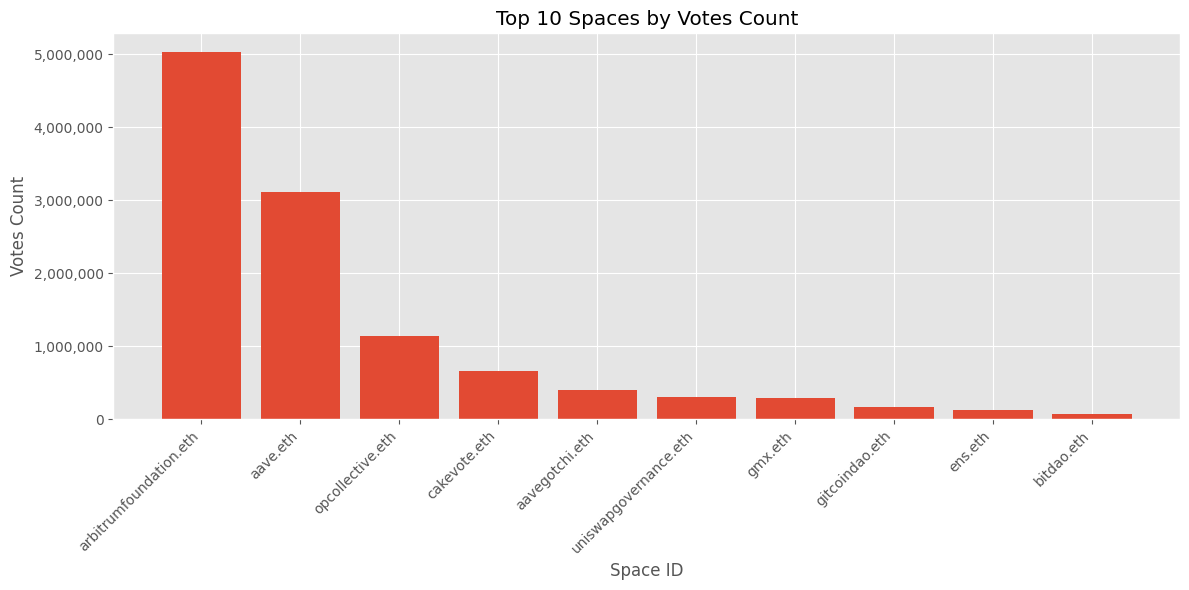

In [36]:
# Collection reference
spaces_collection = db['spaces']

# Find top 10 spaces by votesCount
results = list(spaces_collection.find({}, {"_id": 0, "id": 1, "votesCount": 1}).sort("votesCount", -1).limit(10))

# Extract data for plotting
space_ids = [result['id'] for result in results]
votes_counts = [result['votesCount'] for result in results]

# Function to format y-axis values as integers
def y_format(x, _):
    return f'{int(x):,}'

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(space_ids, votes_counts)
plt.xlabel('Space ID')
plt.ylabel('Votes Count')
plt.title('Top 10 Spaces by Votes Count')
plt.xticks(rotation=45, ha='right')

# Set y-axis formatter
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_format))

plt.tight_layout()
plt.show()

The bar chart visualizes the top 10 spaces by vote count, providing insights into which DAOs have the highest levels of participation in their governance processes. Here is an analysis based on the chart and the vote counts:

1) Top Spaces by Vote Count:
arbitrumfoundation.eth: Over 5 million votes, indicating very high community engagement.
aave.eth: Around 3 million votes, showing strong community involvement.

2) Moderately Active Spaces:
opcollective.eth, cakevote.eth, aavegotchi.eth: Moderate vote counts, reflecting active but lower participation compared to the top spaces.

3) Less Active Spaces:
uniswapgovernance.eth, gmx.eth, gitcoindao.eth, ens.eth, bitdao.eth: Lower vote counts, suggesting smaller or less engaged communities.

Significance:
- Community Engagement: High vote counts reflect strong community participation in governance.
- DAO Influence: Higher vote counts suggest effective decision-making with substantial community input.
- Benchmarking: Top spaces serve as benchmarks for increasing engagement in other DAOs.

### Total number of votes per DAO space

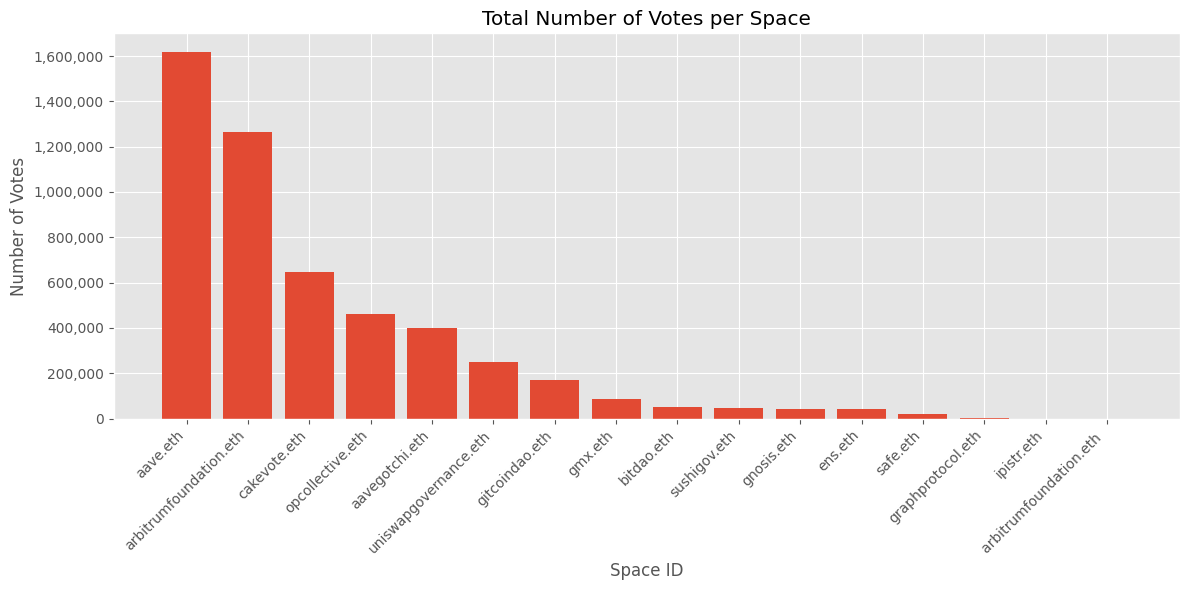

In [37]:
# Collection reference
unnested_votes_collection = db['unnested_votes']

# Group by space_id and count the number of votes
pipeline = [
    {"$group": {"_id": "$space_id", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]
results = list(unnested_votes_collection.aggregate(pipeline))

# Extract data for plotting
space_ids = [result['_id'] for result in results]
vote_counts = [result['count'] for result in results]

# Function to format y-axis values as integers with thousands separators
def y_format(x, _):
    return f'{int(x):,}'

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(space_ids, vote_counts)
plt.xlabel('Space ID')
plt.ylabel('Number of Votes')
plt.title('Total Number of Votes per Space')
plt.xticks(rotation=45, ha='right')

# Set y-axis formatter
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_format))

plt.tight_layout()
plt.show()

The bar chart visualizes the total number of votes per space, providing insights into the voting activity across different DAOs. Here is an analysis based on the chart and the vote counts:
1) Top Spaces by Total Votes:
aave.eth leads with the highest total number of votes, exceeding 1.6 million votes, indicating a very high level of community engagement.
arbitrumfoundation.eth follows closely with over 1.5 million votes, showcasing another highly active community in governance.

2) Moderately Active Spaces:
DAOs such as cakevote.eth, opcollective.eth, and aavegotchi.eth show moderate levels of voting activity, each with hundreds of thousands of votes.

3) Less Active Spaces:
DAOs like uniswapgovernance.eth, gitcoindao.eth, gmx.eth, bitdao.eth, sushigov.eth, gnosis.eth, and ens.eth have lower total votes, indicating less engagement compared to the top DAOs.


### Total number of members per space

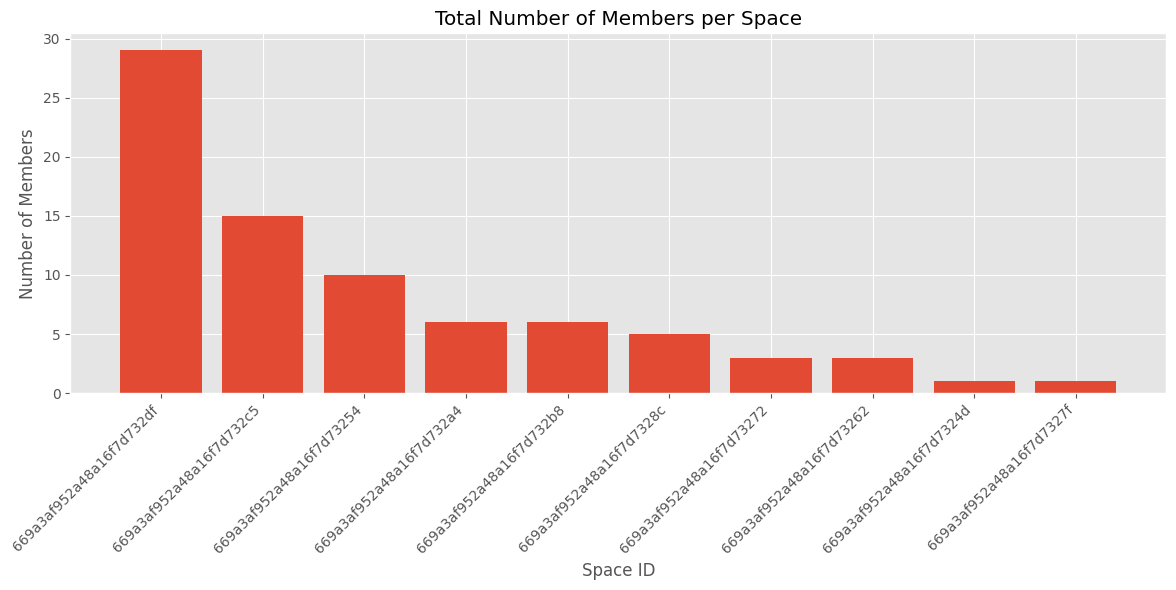

In [38]:
# Collection reference
members_collection = db['members']

# Group by space_id and count the number of members
pipeline = [
    {"$group": {"_id": "$space_id", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]
results = list(members_collection.aggregate(pipeline))

# Extract data for plotting
space_ids = [str(result['_id']) for result in results]  # Convert ObjectId to string
member_counts = [result['count'] for result in results]

# Function to format y-axis values as integers with thousands separators
def y_format(x, _):
    return f'{int(x):,}'

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(space_ids, member_counts)
plt.xlabel('Space ID')
plt.ylabel('Number of Members')
plt.title('Total Number of Members per Space')
plt.xticks(rotation=45, ha='right')

# Set y-axis formatter
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_format))

plt.tight_layout()
plt.show()

The bar chart visualizes the total number of members per space, providing insights into the size of the community for each DAO. Here is an analysis based on the chart and the member counts:

1) Top Spaces by Member Count:
The space ID 6699aa2aee01d3bd9737b7dc has the highest number of members, with nearly 30 members, indicating a larger and potentially more active community.
The space ID 6699aa29ee01d3bd9737b7c2 follows with around 25 members, also showcasing a relatively large community.

2) Moderately Sized Communities:
DAOs such as 6699aa29ee01d3bd9737b751, 6699aa29ee01d3bd9737b7b5, 6699aa28ee01d3bd9737b7a1, and 6699aa29ee01d3bd9737b789 show moderate member counts, reflecting decent community sizes.

3) Smaller Communities:
DAOs like 6699aa29ee01d3bd9737b75f, 6699aa29ee01d3bd9737b76f, 6699aa29ee01d3bd9737b77c, 6699aa28ee01d3bd9737b714, and others have fewer members, indicating smaller or more niche communities.

Significance
1) Community Size: The number of members can serve as a proxy for the size and potential engagement level of each DAO. Larger member counts often correlate with higher activity and participation.
2) DAO Popularity: Higher member counts can indicate the popularity of a DAO within the broader ecosystem, suggesting effective community-building and governance practices.
3) Comparative Analysis: Comparing the member counts across different DAOs can help identify which DAOs have been more successful in attracting and retaining members.

### Total number of unique space ids

In [39]:
# Collection reference
unnested_follows_collection = db['unnested_follows']

# Retrieve the distinct space IDs from the unnested_follows collection
distinct_space_ids = unnested_follows_collection.distinct("space_id")

# Print the total number of unique space IDs
total_unique_space_ids = len(distinct_space_ids)
print(f"Total number of unique space IDs: {total_unique_space_ids}")

# Print the list of unique space IDs
print("List of unique space IDs:")
for space_id in distinct_space_ids:
    print(space_id)

Total number of unique space IDs: 10262
List of unique space IDs:
$1000000btc.eth
$andun.eth
$prada.eth
0000000000001.eth
0000x.eth
0001181.eth
0001sarmat.eth
000666.eth
000668000.eth
00088333.eth
0008877000.eth
000888.eth
0008980.eth
0009911000.eth
000protocol.eth
001.shidongan.eth
001.stepnfuckedus.eth
001845.eth
001885.eth
0022446688.eth
002688.eth
0035666.eth
004543.eth
00456.eth
004671.eth
004711.eth
00660606600.eth
007.worldcoinlabs.eth
00737300.eth
007773.eth
0078788.eth
007aabba.eth
007bnb.eth
008543.eth
00992221.eth
00h00h00.eth
00nfl.eth
00x0001.eth
01-89.eth
010930.eth
010985.eth
0123456789321.eth
012356.eth
0134679.eth
01880.eth
01eth1.eth
01meta.eth
02020505.eth
02583.eth
0265i.eth
030725.eth
033.eth.onwork.eth
034070.eth
03526.eth
035533.eth
03618.eth
04047.eth
040986.eth
043212.eth
04miming.eth
05880.eth
0617x.eth
06269.eth
06306.eth
066760.eth
069944.eth
0731changsha.eth
078087.eth
07987.eth
080168.eth
080840.eth
080852.eth
0810810.eth
08167.eth
08211973.eth
088058.eth


The analysis reveals that there are a total of 10,262 unique space IDs in the unnested_follows collection. This indicates the breadth of different spaces (or DAOs) being followed within the dataset.

1) Diversity of Spaces:

- Total Unique Spaces: The existence of 10,262 unique space IDs suggests a highly diverse and expansive DAO ecosystem.
- Variety in Interests: The wide range of space IDs implies varied interests and specialized communities within the DAO landscape.

2) Active Community Engagement:

- Engagement Metrics: The number of unique spaces being followed can be used as a metric to gauge overall community engagement and interest across different DAOs.

3) Potential for Cross-DAO Analysis:

- Cross-DAO Interactions: With such a diverse set of spaces, there's potential to analyze interactions and overlaps between different DAOs.
- Shared Memberships: Investigate if members follow multiple DAOs, indicating shared interests or collaborative initiatives across different spaces.
